# Ebisu with Generalized Beta Distributions

It turns out that the time-shifted Beta distributions used in Ebisu correspond to a known probability distribution: the [Generalized Beta Distribution of the First Kind (GB1)](https://en.wikipedia.org/wiki/Generalized_beta_distribution#Generalized_beta_of_first_kind_(GB1)).
Using this distribution can simplify some of the updates and introduce fewer approximations.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas
from scipy.special import gammaln
from scipy import integrate, optimize, stats

import ebisu

plt.style.use('seaborn-darkgrid')


## Quick Updates

I'd like to see what the Ebisu algorithm would have to say about my current log of Anki reviews.
Because Anki wasn't using the Ebisu algorithm to schedule reviews, sometimes reviews of the same note happen in quick succession.
I suspect that this may cause a problem in Ebisu's algorithm, which uses the interval between the last two reviews as the reference time to project out a Beta distribution to future times.

/home/rkern/.edm/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
/home/rkern/git/ebisu/ebisu/alternate.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  alpha /


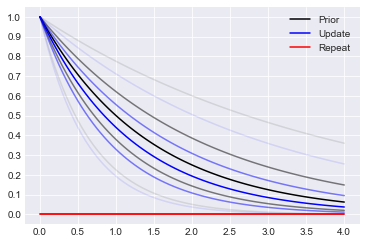

In [2]:
def plot_decay(prior, ts, color='black', label=None, qs=(0.05, 0.25, 0.5, 0.75, 0.95)):
    rows = []
    for t in ts:
        row = []
        for q in qs:
            row.append(ebisu.alternate.predictRecallMedian(prior, t, q))
        rows.append(row)
    scores = np.asarray(rows).T
    for i, (q, score) in enumerate(zip(qs, scores)):
        alpha = 1.0 - 2*abs(q - 0.5)
        plt.plot(ts, score, color=color, alpha=alpha, label=label if q == 0.5 else None)

ts = np.linspace(0.0, 4.0, 81.0)

# Standard initial model with a half-life at time 1.0 (arbitrary units)
model0 = (4.0, 4.0, 1.0)
# Let's review and observe a negative recall at the half-life.
model1 = ebisu.updateRecall(model0, False, 1.0)
# Now let's review and observe a positive recall very quickly after that.
# Let's say that Anki made me re-test very soon after my failure.
model2 = ebisu.updateRecall(model1, True, 0.01)

plot_decay(model0, ts, label='Prior')
plot_decay(model1, ts, color='blue', label='Update')
plot_decay(model2, ts, color='red', label='Repeat')
plt.yticks(np.linspace(0.0, 1.0, 11));
plt.legend();

Hmm.
The `Repeat` decay is showing severe numerical issues.
Unfortunately, if I were to apply the Ebisu algorithm to my Anki log, I'd probably have a lot of these due to Anki's algorithm for lapses.

In [3]:
def simulate_probs(model, tnow, size, random_state=np.random):
    """Draw a given number of time-evolved Bernoulli probabilities.
    """
    alpha, beta, t0 = model
    delta = tnow / t0
    q = stats.beta.rvs(alpha, beta, size=size, random_state=random_state)
    p = q ** delta
    return p

def simulate_posterior(model, tnow, obs, size, random_state=np.random):
    """Rejection algorithm for simulating the posterior given an observation at time `tnow`.
    """
    matching_draws = []
    while len(matching_draws) < size:
        # Draw time-evolved p values, then conduct Bernoulli trials.
        p = simulate_probs(model, tnow, size, random_state=random_state)
        matching = (random_state.random_sample(size) < p) == obs
        # Keep those that match the observation.
        matching_draws.extend(p[matching])
    matching_draws = np.asarray(matching_draws[:size])
    return matching_draws

def genbeta1_pdf(x, alpha, beta, delta):
    """PDF of the GB1 distribution.
    """
    y = np.power(x, 1/delta)
    with np.errstate(invalid='ignore', divide='ignore'):
        logz = stats.beta.logpdf(y, alpha, beta) + np.log(y) - np.log(x) - np.log(delta)
        logz[x == 0] = -np.inf  # not always right, but usually.
    return np.exp(logz)

def plot_genbeta1(model, tnow):
    """Plot the GB1 distribution implied by evolving the model for a given time.
    """
    x = np.linspace(0.0, 1.0, 101)
    alpha, beta, t0 = model
    delta = tnow / t0
    y = genbeta1_pdf(x, alpha, beta, delta)
    plt.plot(x, y, 'k-')

def posterior_pdf(prior, tnow, obs):
    """PDF of the posterior.
    
    The normalization constant is estimated by numerical integration.
    """
    x = np.linspace(0.0, 1.0, 101)
    alpha, beta, t0 = prior
    delta = tnow / t0
    prior_pdf = genbeta1_pdf(x, alpha, beta, delta)
    if obs:
        posterior_pdf = prior_pdf * x
    else:
        posterior_pdf = prior_pdf * (1 - x)
    Z = integrate.trapz(posterior_pdf, x)
    posterior_pdf /= Z
    return x, posterior_pdf

def plot_posterior_pdf(model, tnow, obs):
    x, posterior = posterior_pdf(model, tnow, obs)
    plt.plot(x, posterior, 'r-')

def _subtractexp(x, y):
    """Evaluates exp(x) - exp(y) a bit more accurately than that. ⚾️

    This can avoid cancellation in case `x` and `y` are both large and close,
    similar to scipy.misc.logsumexp except without the last log.
    """
    from numpy import exp, maximum
    maxval = maximum(x, y)
    return exp(maxval) * (exp(x - maxval) - exp(y - maxval))

def posterior_moments(prior, tnow, obs):
    """Give the first two moments (and variance, computed accurately) of a posterior.
    """
    from scipy.special import gammaln
    from numpy import exp
    alpha, beta, t = prior
    dt = tnow / t
    if obs:
        # marginal: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*p, {p,0,1}]`
        # mean: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*p*p, {p,0,1}]`
        # variance: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*p*(p - m)^2, {p,0,1}]`
        # Simplify all three to get the following:
        same = gammaln(alpha + beta + dt) - gammaln(alpha + dt)
        muln = gammaln(alpha + 2 * dt) - gammaln(alpha + beta + 2 * dt) + same
        mu = exp(muln)
        var = _subtractexp(
            same + gammaln(alpha + 3 * dt) - gammaln(alpha + beta + 3 * dt),
            2 * muln)
    else:
        # Mathematica code is same as above, but replace one `p` with `(1-p)`
        # marginal: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*(1-p), {p,0,1}]`
        # mean: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*(1-p)*p, {p,0,1}]`
        # var: `Integrate[p^((a - t)/t)*(1 - p^(1/t))^(b - 1)*(1-p)*(p - m)^2, {p,0,1}]`
        # Then simplify and combine

        from scipy.special import logsumexp
        from numpy import expm1

        s = [
            gammaln(alpha + n * dt) - gammaln(alpha + beta + n * dt)
            for n in range(4)
        ]

        mu = expm1(s[2] - s[1]) / -expm1(s[0] - s[1])

        def lse(a, b):
          return list(logsumexp(a, b=b, return_sign=True))

        n1 = lse([s[1], s[0]], [1, -1])
        n1[0] += s[3]
        n2 = lse([s[0], s[1], s[2]], [1, 1, -1])
        n2[0] += s[2]
        n3 = [s[1] * 2, 1.]
        d = lse([s[1], s[0]], [1, -1])
        d[0] *= 2
        n = lse([n1[0], n2[0], n3[0]], [n1[1], n2[1], -n3[1]])
        var = exp(n[0] - d[0])
    m2 = var + mu*mu
    return mu, m2, var

def genbeta1_moments(alpha, beta, delta):
    """Compute the first two moments (and variance, computed accurately) of a GB1 distribution.
    """
    lgn = [gammaln(alpha + n*delta) - gammaln(alpha + beta + n*delta) for n in range(3)]
    lm1 = lgn[1] - lgn[0]
    lm2 = lgn[2] - lgn[0]
    var = _subtractexp(lm2, 2*lm1)
    m1 = np.exp(lm1)
    m2 = np.exp(lm2)
    return m1, m2, var

def match_moments(m1, m2, prior, tnow, obs):
    """Do a least-squares fit of the first two moments of a GB1 distribution to the given moments.
    
    Only `alpha` and `beta` are modified. `delta` (or equivalently, the time constant from the
    prior model) is kept fixed. The (prior, tnow, obs) provide or derive the starting values for
    `alpha`, `beta`, and the fixed `delta`.
    
    Another idea to try would be to muck around with `beta` and `delta` instead of `alpha` and `beta`.
    """
    alpha0, beta0, t0 = prior
    delta = tnow / t0
    ab0 = np.array([alpha0, beta0])
    if obs:
        ab0[0] += delta
    else:
        # No idea about this, really.
        ab0[1] += np.power(1/delta, 1/beta0)

    def f(ab):
        alpha, beta = ab
        mom1, mom2, _ = genbeta1_moments(alpha, beta, delta)
        return np.array([mom1, mom2]) - np.array([m1, m2])

    return optimize.least_squares(f, ab0, bounds=((1.1, 1.1), (np.inf, np.inf)))

Okay, we've built up some tools for simulating posteriors, numerically evaluating them, and fitting them to GB1 distributions.
Now let's explore how well it does.

Old Model: (1000.0, 4.0, 1.0)
New Model: (1000.0302748155815, 4.9781760438541145, 1.0)


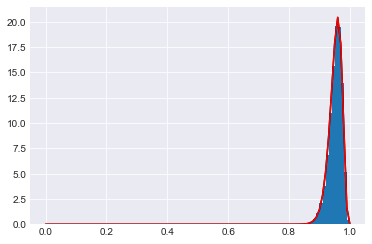

In [4]:
# Play around with these values.
tnow = 10.0
model0 = (1000.0, 4.0, 1.0)  # WLOG, leave t=1.0 alone.
obs = False


# Compute the updates.
alpha0, beta0, t0 = model0
delta = tnow / t0
if obs:
    # This one is simple.
    alpha1 = alpha0 + delta
    beta1 = beta0
    t1 = t0
else:
    # This one is hard.
    m1, m2, var = posterior_moments(model0, tnow, obs)
    res = match_moments(m1, m2, model0, tnow, obs)
    alpha1, beta1 = res.x
    t1 = t0

# This is our updated model.
model1 = (alpha1, beta1, t1)

print(f'Old Model: {model0!r}')
print(f'New Model: {model1!r}')

plt.hist(simulate_posterior(model0, tnow, obs, 100000), bins=np.linspace(0.0, 1.0, 101), density=True);
plot_genbeta1(model1, tnow);
plot_posterior_pdf(model0, tnow, obs)

Let's check how good our approximation is systematically.
Let's try all combinations of low/high `alpha`, `beta`, and `delta`.

In [5]:
rows = []
for alpha0 in [2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 40.0, 100.0, 200.0, 400.0]:
    for beta0 in [2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 40.0, 100.0, 200.0, 400.0]:
        for delta in [0.1, 0.2, 0.5, 0.9, 1.1, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0]:
            prior = (alpha0, beta0, 1.0)
            m1, m2, _ = posterior_moments(prior, delta, False)
            res = match_moments(m1, m2, prior, delta, False)
            alpha1, beta1 = res.x
            gb1_m1, gb1_m2, _ = genbeta1_moments(alpha1, beta1, delta)
            rows.append([alpha0, beta0, delta, m1, m2, alpha1, beta1, gb1_m1, gb1_m2, res.cost])
df = pandas.DataFrame(data=rows, columns=['alpha0', 'beta0', 'delta', 'm1', 'm2', 'alpha1', 'beta1', 'gb1_m1', 'gb1_m2', 'cost'])
df

,alpha0,beta0,delta,m1,m2,alpha1,beta1,gb1_m1,gb1_m2,cost
0,2.0,2.0,0.1,0.885695,0.788334,1.750435,3.166961,0.885701,0.788331,2.062786e-11
1,2.0,2.0,0.2,0.791855,0.638125,1.781546,3.134171,0.791855,0.638125,4.157234e-15
2,2.0,2.0,0.5,0.590909,0.378788,1.875927,3.076521,0.590909,0.378788,2.040144e-16
3,2.0,2.0,0.9,0.429304,0.223608,1.977782,3.013687,0.429304,0.223608,1.272516e-21
4,2.0,2.0,1.1,0.373807,0.180006,2.021147,2.987003,0.373807,0.180006,6.446924e-23
5,2.0,2.0,1.5,0.292308,0.124260,2.096673,2.940982,0.292308,0.124260,7.237300e-17
6,2.0,2.0,2.0,0.224490,0.085034,2.175294,2.894125,0.224490,0.085034,2.053689e-17
7,2.0,2.0,3.0,0.145833,0.047348,2.297996,2.824344,0.145833,0.047348,6.098214e-20
8,2.0,2.0,4.0,0.103030,0.030303,2.391875,2.774718,0.103030,0.030303,2.000240e-17
9,2.0,2.0,5.0,0.076923,0.021116,2.467880,2.737487,0.076923,0.021116,3.819787e-16


Okay! That's not bad!

In [6]:
df.cost.max()

2.5219073742429606e-09

In [7]:
df.loc[df.cost.idxmax()]

alpha0    2.000000e+02
beta0     1.000000e+01
delta     1.000000e+01
m1        5.980217e-01
m2        3.659543e-01
alpha1    2.007902e+02
beta1     1.083048e+01
gb1_m1    5.979672e-01
gb1_m2    3.659999e-01
cost      2.521907e-09
Name: 934, dtype: float64

Okay, so in the worst cases, good to about 3-4 decimal places for the moments. That's pretty reasonable.